In [1]:
import os
import sys
sys.path.append('.')
# import glog as log
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

from utils.utils import load_model_state
from evaluate import evaluate, compute_embeddings_lfw

from datasets.twins import TwinPairsDataset, ClassificationDataset
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

TWINS_ROOT = '/home/user/data/twins_aligned_eyes_resized'
DF_ROOT='/home/user/data/twins_aligned_cropped_resized'
THRESHOLD = 0.13

In [2]:
checkpoint = 'snapshots/r18do0.5_320_twins_rot0.772.pt'

### Data

In [3]:
from albumentations import Compose, Normalize, CenterCrop, Resize
from albumentations.torch import ToTensor

input_size = (320, 320)

transform = Compose([
                     Resize(*input_size)],
                   to_tensor=ToTensor(), additional_targets={'image1': 'image'})

# front images for each id
views = pd.read_csv(os.path.join(DF_ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs_test = pd.read_csv(os.path.join(DF_ROOT, 'df', 'pairs_test_fedor.csv'))
pairs_test['id_1']=pairs_test['id_1'].astype(int)
pairs_test['id_2']=pairs_test['id_2'].astype(int)
test_dataset = TwinPairsDataset(TWINS_ROOT, pairs_test, views, transform=transform, \
                                keypoints=False)
print(len(test_dataset))

277


In [4]:
test_dataset[0].keys()

dict_keys(['img1', 'img2', 'is_same', 'id0', 'id1'])

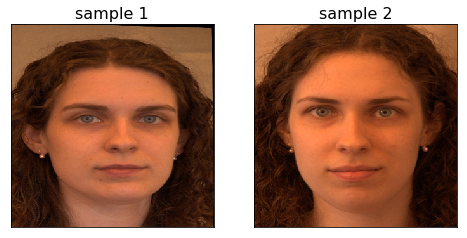

In [5]:
sample1 = test_dataset[0]['img1']
sample2 = test_dataset[0]['img2']
f,a = plt.subplots(1,2, figsize=(8,5))
a[0].imshow(sample2.numpy().transpose(1,2,0))
a[0].set_title('sample 1', fontsize=16)
a[1].imshow(sample1.numpy().transpose(1,2,0))
a[1].set_title('sample 2', fontsize=16)
# a[2].imshow(np.flip(sample2.numpy().transpose(1,2,0),1))
# a[2].set_title('sample 1 flipped', fontsize=16)

for ax in a:
    ax.grid(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

### Model

In [6]:
from model.resnet_angular import ResNetAngular
from torchvision.models import resnet18

import torch.nn as nn
import torch

In [7]:
backbone = resnet18(pretrained=True)
backbone.avgpool = nn.AdaptiveAvgPool2d(1)
backbone.fc = nn.Dropout(0.1)

In [8]:
num_classes=286
model = ResNetAngular(backbone, embedding_size=512, num_classes=num_classes, feature=False)

In [9]:
print('Resuming snapshot ', checkpoint)
model = load_model_state(model, checkpoint, 0, eval_state=False)
model.cuda()

Resuming snapshot  snapshots/r18do0.5_320_twins_rot0.772.pt


ResNetAngular(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [10]:
model.eval()
scores_with_gt = compute_embeddings_lfw(test_dataset, model, 16, dump_embeddings=False)

TypeError: compute_embeddings_lfw() missing 1 required positional argument: 'batch_size'

In [11]:
scores = [s['score'] for s in scores_with_gt]
gt = [s['is_same'].item() for s in scores_with_gt]

In [12]:
((np.array(scores)<THRESHOLD).astype(int)==gt).mean()

0.7906137184115524